In [2]:
import torch
import torch.nn as nn
from transformers import AdamW, AutoTokenizer
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy

/Users/nguyenhuuduy/Desktop/立命館大学/BOOKS+MATERIAL/5th_Semester/31801 PBL 5 Design Evolution (G2)/Project/vihsd/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define the CNN model with Dropout layers
class CNN(nn.Module):
    def __init__(self, num_labels):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(128, num_labels)

    def forward(self, x):
        x = x.transpose(1, 2)  # Transpose before passing to Conv1d
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool1d(kernel_size=2)(x)
        x = self.dropout(x)
        x = torch.mean(x, dim=2)
        x = self.fc(x)
        return x

In [5]:

# Load the dataset
data = pd.read_csv('data/new_vihsd.csv')
data['free_text'] = data['free_text'].astype(str)

# Print DataFrame info
print(data.info())
print(data.head())

overall_label_counts = data['label_id'].value_counts()
print("Label counts in the entire dataset:")
print(overall_label_counts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31706 entries, 0 to 31705
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label_id   31706 non-null  int64 
 1   free_text  31706 non-null  object
dtypes: int64(1), object(1)
memory usage: 495.5+ KB
None
   label_id                                          free_text
0         0  em được làm fan cứng luôn rồi nè ️ reaction qu...
1         0           đậu văn cường giờ giống thằng sida hơn à
2         0    từ lý_thuyết đến thực_hành là cả câu_chuyện dài
3         0                             coronavirus is manmade
4         0                            đố chúng_mày nhận ra ai
Label counts in the entire dataset:
label_id
0    15853
1    15853
Name: count, dtype: int64


In [6]:
# Ensure label_id is properly encoded
data['label_id'] = data['label_id'].astype(int)
data_0 = data[data['label_id'] == 0]
data_1 = data[data['label_id'] == 1]

In [7]:
# Define split sizes
train_size = 0.7
validation_size = 0.1
test_size = 0.2

# Calculate validation and test size from the remaining dataset after train split
post_train_size = 1 - train_size
validation_size_adjusted = validation_size / post_train_size

In [8]:
# Split data for label 0
train_0, temp_0 = train_test_split(data_0, train_size=train_size, random_state=42, stratify=data_0['label_id'])
dev_0, test_0 = train_test_split(temp_0, test_size=validation_size_adjusted, random_state=42, stratify=temp_0['label_id'])

# Split data for label 1
train_1, temp_1 = train_test_split(data_1, train_size=train_size, random_state=42, stratify=data_1['label_id'])
dev_1, test_1 = train_test_split(temp_1, test_size=validation_size_adjusted, random_state=42, stratify=temp_1['label_id'])

# Combine the splits from each label into final subsets
train = pd.concat([train_0, train_1]).sample(frac=1, random_state=42)
dev = pd.concat([dev_0, dev_1]).sample(frac=1, random_state=42)
test = pd.concat([test_0, test_1]).sample(frac=1, random_state=42)

In [9]:
# Separating features and labels
X_train, y_train = train['free_text'], train['label_id']
X_val, y_val = dev['free_text'], dev['label_id']
X_test, y_test = test['free_text'], test['label_id']

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 22194
Validation size: 6340
Test size: 3172


In [10]:
from sklearn.model_selection import train_test_split

# Splitting the data
train, temp = train_test_split(data, train_size=0.7, stratify=data['label_id'], random_state=42)
valid, test = train_test_split(temp, test_size=0.6667, stratify=temp['label_id'], random_state=42)  # 0.6667 * 0.3 = 0.2


/var/folders/9p/h79vy3_s10b2njdrf2gvn7yh0000gn/T/ipykernel_92565/2008011539.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_id', data=data, palette='viridis')


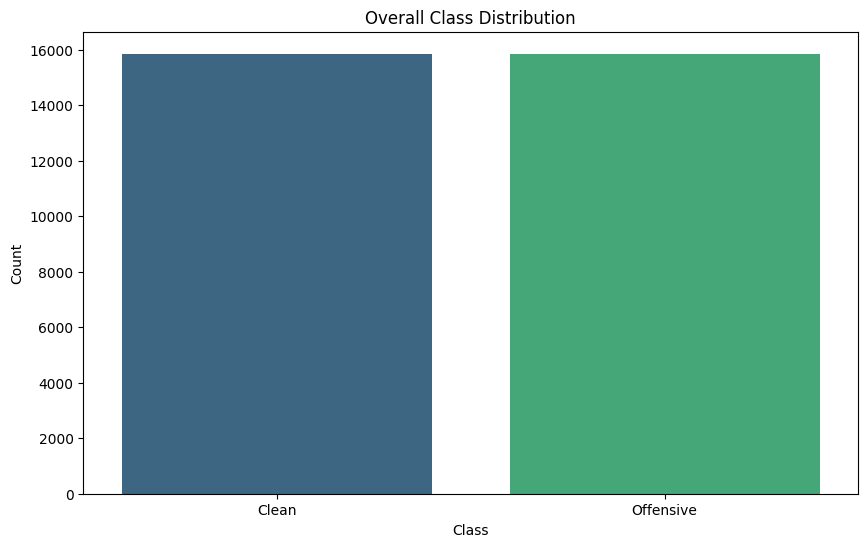

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label_id', data=data, palette='viridis')
plt.title('Overall Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Clean', 'Offensive'])
plt.show()


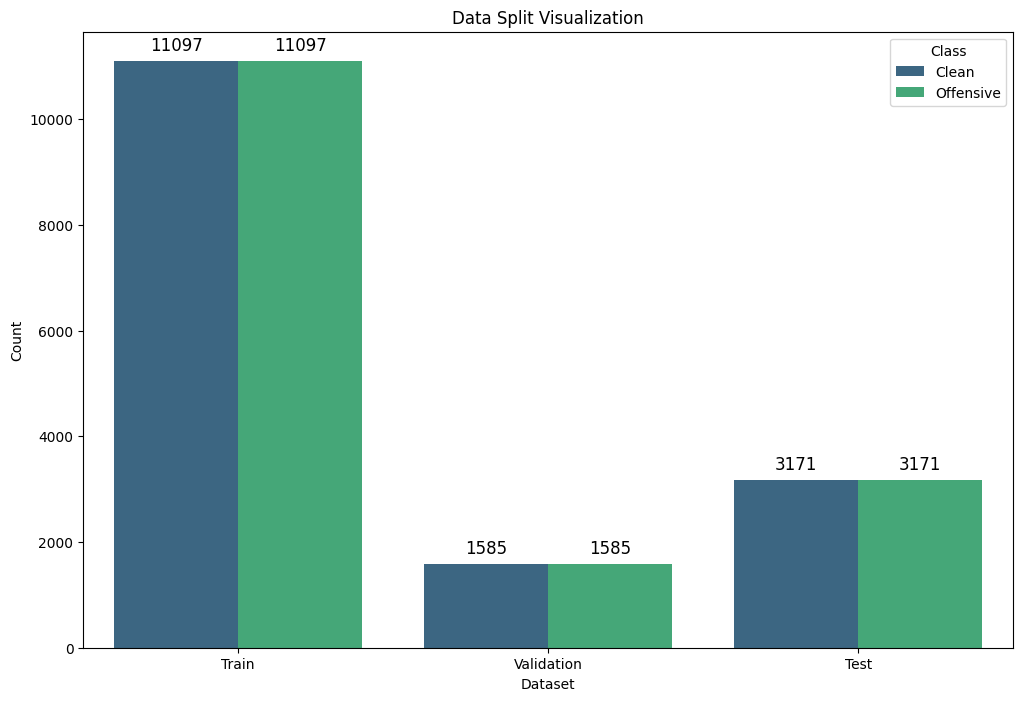

In [24]:
# Creating a DataFrame for split visualization
split_data = pd.DataFrame({
    'Dataset': ['Train'] * len(train) + ['Validation'] * len(valid) + ['Test'] * len(test),
    'Class': train['label_id'].tolist() + valid['label_id'].tolist() + test['label_id'].tolist()
})

# Plotting the data split visualization with Annotations
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='Dataset', hue='Class', data=split_data, palette='viridis')
plt.title('Data Split Visualization')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.legend(title='Class', labels=['Clean', 'Offensive'])

# Adding text annotations for the total count of texts in each set
for p in ax.patches:
    if p.get_height() > 0:  # Ensure we only annotate non-zero height bars
        height = p.get_height()
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.show()


In [10]:
# Tokenization and Dataset Preparation
from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
phobert = AutoModel.from_pretrained("vinai/phobert-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [11]:
def encoder_generator(X, y):
    encoded = tokenizer.batch_encode_plus(X.tolist(), padding=True, truncation=True, max_length=256, return_tensors='pt')
    input_ids = encoded['input_ids']
    attention_masks = encoded['attention_mask']
    labels = torch.tensor(y.tolist(), dtype=torch.long)
    return input_ids, attention_masks, labels

train_input_ids, train_attention_masks, train_labels = encoder_generator(X_train, y_train)
val_input_ids, val_attention_masks, val_labels = encoder_generator(X_val, y_val)
test_input_ids, test_attention_masks, test_labels = encoder_generator(X_test, y_test)


In [12]:
# Create TensorDatasets and DataLoaders
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_data = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)
test_sampler = SequentialSampler(test_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=32)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

In [13]:
# Define the training function
def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, masks, labels in dataloader:
        inputs = inputs.to(device)
        masks = masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Get the PhoBERT output
        with torch.no_grad():
            phoBERT_outputs = phoBert(input_ids=inputs, attention_mask=masks)
            embedded = phoBERT_outputs.last_hidden_state

        # Pass the PhoBERT output to the CNN model
        outputs = model(embedded)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc.item()

In [20]:
# Define the evaluation function
from sklearn.metrics import classification_report, accuracy_score, f1_score

def eval(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, masks, labels in dataloader:
            inputs = inputs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            # Get the PhoBERT output
            phoBERT_outputs = phoBert(input_ids=inputs, attention_mask=masks)
            embedded = phoBERT_outputs.last_hidden_state

            # Pass the PhoBERT output to the CNN model
            outputs = model(embedded)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_acc.item(), macro_f1

In [15]:
# Define epoch time calculation
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [16]:
# Load the models
from transformers import AutoModel

phoBert = AutoModel.from_pretrained('vinai/phobert-base')
phoBert = phoBert.to(device)

cnn = CNN(num_labels=2).to(device)


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [17]:
# Define criterion, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(cnn.parameters(), lr=1e-5, weight_decay=1e-2)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# Create dataloaders
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}


In [ ]:
import torch.nn as nn

class PhoBERTClassifier(nn.Module):
    def __init__(self, phobert):
        super(PhoBERTClassifier, self).__init__()
        self.phobert = phobert
        self.classifier = nn.Linear(phobert.config.hidden_size, 2)  # Assuming binary classification

    def forward(self, input_ids, attention_mask):
        outputs = self.phobert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        logits = self.classifier(sequence_output[:, 0, :])
        return logits

model = PhoBERTClassifier(phobert)

In [21]:
# Training loop with visualization
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

epochs = 8
best_macro_f1 = float('0')

for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc = train(cnn, train_dataloader, criterion, optimizer)
    valid_loss, valid_acc, macro_f1 = eval(cnn, val_dataloader, criterion)
    end_time = time.time()

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        torch.save(phoBert, '/content/phobert_cnn_model_part1_task2a_2.pt')
        torch.save(cnn, '/content/phobert_cnn_model_part2_task2a_2.pt')
        print("Model saved")

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')
    print(f'\tVal. F1: {macro_f1*100:.2f}%')
    print('=============Epoch Ended==============')

Model saved
Epoch: 01 | Epoch Time: 6m 16s
	Train Loss: 0.420 | Train Acc: 81.59%
	Val. Loss: 0.409 | Val. Acc: 81.66%
	Val. F1: 81.66%
=============Epoch Ended==============
Model saved
Epoch: 02 | Epoch Time: 6m 16s
	Train Loss: 0.396 | Train Acc: 82.57%
	Val. Loss: 0.400 | Val. Acc: 81.91%
	Val. F1: 81.90%
=============Epoch Ended==============
Model saved
Epoch: 03 | Epoch Time: 6m 17s
	Train Loss: 0.384 | Train Acc: 83.09%
	Val. Loss: 0.392 | Val. Acc: 82.35%
	Val. F1: 82.34%
=============Epoch Ended==============
Epoch: 04 | Epoch Time: 6m 16s
	Train Loss: 0.376 | Train Acc: 83.62%
	Val. Loss: 0.386 | Val. Acc: 82.26%
	Val. F1: 82.25%
=============Epoch Ended==============
Model saved
Epoch: 05 | Epoch Time: 6m 16s
	Train Loss: 0.370 | Train Acc: 83.85%
	Val. Loss: 0.384 | Val. Acc: 82.71%
	Val. F1: 82.71%
=============Epoch Ended==============
Epoch: 06 | Epoch Time: 6m 16s
	Train Loss: 0.364 | Train Acc: 84.05%
	Val. Loss: 0.380 | Val. Acc: 82.54%
	Val. F1: 82.53%
=============

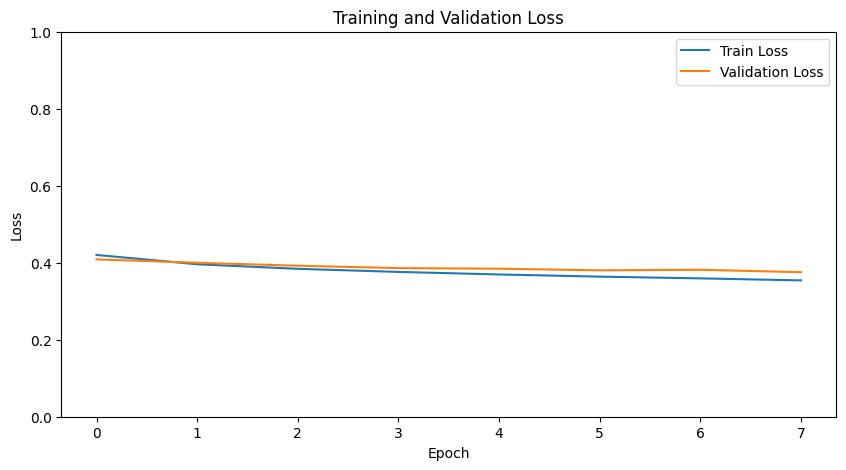

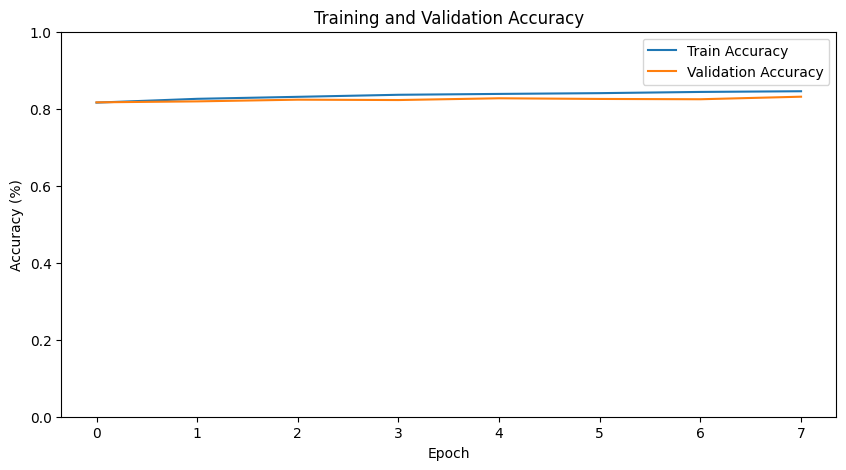

In [22]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.xticks(np.arange(epochs))  # Set x-axis ticks to integers
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 (percentage scale)
plt.xticks(np.arange(epochs))  # Set x-axis ticks to integers
plt.legend()
plt.show()


In [23]:
# Evaluate the model on the test set
def predict(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, masks, labels = batch
            inputs = inputs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            # Get the PhoBERT output
            phoBERT_outputs = phoBert(input_ids=inputs, attention_mask=masks)
            embedded = phoBERT_outputs.last_hidden_state

            # Pass the PhoBERT output to the CNN model
            outputs = model(embedded)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Example usage
test_predictions, test_true_labels = predict(cnn, test_dataloader)

# Print classification report
print(classification_report(test_true_labels, test_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.8410    0.8272    0.8341      1586
           1     0.8300    0.8436    0.8368      1586

    accuracy                         0.8354      3172
   macro avg     0.8355    0.8354    0.8354      3172
weighted avg     0.8355    0.8354    0.8354      3172



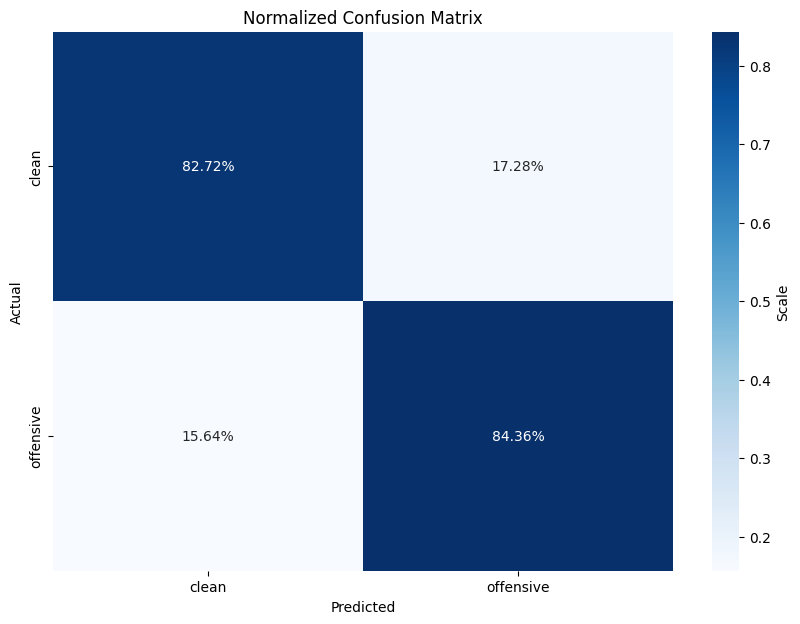

In [24]:
# Compute and plot confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Convert the normalized confusion matrix to DataFrame
labels = ['clean', 'offensive']
cm_df = pd.DataFrame(cm_normalized, index=labels, columns=labels)

# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt=".2%", cmap='Blues', cbar_kws={'label': 'Scale'})
plt.title('Normalized Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()